In [1]:
import tensorflow as tf
import time

from HanSequenceLabellingModel import HanSequenceLabellingModel

%load_ext autoreload
%autoreload 1
%aimport HanSequenceLabellingModel
%aimport model_components
%aimport

Modules to reload:
HanSequenceLabellingModel model_components

Modules to skip:



In [2]:
import tarfile
import re
import urllib.request
import os
import random

class ImdbMovieReviews:
    DEFAULT_URL = \
        'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    TOKEN_REGEX = re.compile(r'[A-Za-z]+|[!?.:,()]')
    
    def __init__(self):
        self._cache_dir = './imdb'
        self._url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
        
        if not os.path.isfile(self._cache_dir):
            urllib.request.urlretrieve(self._url, self._cache_dir)
        self.filepath = self._cache_dir

    def __iter__(self):
        with tarfile.open(self.filepath) as archive:
            items = archive.getnames()
            for filename in archive.getnames():
                if filename.startswith('aclImdb/train/pos/'):
                    yield self._read(archive, filename), True
                elif filename.startswith('aclImdb/train/neg/'):
                    yield self._read(archive, filename), False
                    
    def _read(self, archive, filename):
        with archive.extractfile(filename) as file_:
            data = file_.read().decode('utf-8')
            data = type(self).TOKEN_REGEX.findall(data)
            data = [x.lower() for x in data]
            return data

In [3]:
import numpy as np
# Spacy is my favourite nlp framework, which havu builtin word embeddings trains on wikipesia
from spacy.en import English

class Embedding:
    
    def __init__(self):
#          spaCy makes using word vectors very easy. 
#             The Lexeme , Token , Span  and Doc  classes all have a .vector property,
#             which is a 1-dimensional numpy array of 32-bit floats:
        self.parser = English()
#         self._length = length
        self.dimensions = 300
        
    def __call__(self, sequence, length):
        # DO I really need them to be equal length?
        # Let's assume I'm not
        data = np.zeros((length, self.dimensions))
        # you can access known words from the parser's vocabulary
        embedded = [self.parser.vocab[w].vector for w in sequence]
        data[:len(sequence)] = embedded
        return data

In [4]:
import itertools

def preprocess_batched_split(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch = []
        labelss = []
        sentence_sizes_batch = []
        for index in range(batch_size):
            text, label = next(iterator)
            sents = [list(y) for x, y in itertools.groupby(text, lambda z: z == '.') if not x]
            sentence_sizes = [len(s) for s in sents]
            text_embed = [embedding(sent) for sent in sents]
            
            batch.append(text_embed)
            labelss.append(label)
            sentence_sizes_batch.append(sentence_sizes)
            
        labels_batch = np.array(labelss, dtype=np.int32)
        sent_per_doc = np.array([len(x) for x in sentence_sizes_batch])
        words_per_sent_per_doc = np.array(sentence_sizes_batch)
        yield np.array(batch), labels_batch, words_per_sent_per_doc, sent_per_doc

In [5]:
import itertools

def preprocess_batched_split2(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch, labels_b = zip(*itertools.islice(iterator, batch_size))
        
        sents_b = [[list(y) for x, y in itertools.groupby(doc, lambda z: z == '.') if not x] for doc in batch]

        sentence_sizes_b = [[len(sent) for sent in doc] for doc in sents_b]
        sentence_size = max(map(max, sentence_sizes_b))
        
        document_sizes = np.array([len(doc) for doc in sentence_sizes_b], dtype=np.int32)
        document_size = document_sizes.max()

        sentence_sizes_np = np.zeros(shape=[batch_size, document_size], dtype=np.int32)
        for bi, ds, ss in zip(range(sentence_sizes_np.shape[0]), document_sizes, sentence_sizes_b):
            sentence_sizes_np[bi][:ds] = ss
        
        text_embed_b = np.zeros((batch_size, document_size, sentence_size, 300))
        for i, ds, doc_sents in zip(range(text_embed_b.shape[0]), document_sizes, sents_b):
            doc_sents_embed = np.array([embedding(sent, sentence_size) for sent in doc_sents])
            text_embed_b[i][:ds] = doc_sents_embed
        
        yield text_embed_b, np.array(labels_b, dtype=np.int32), np.array(document_sizes), sentence_sizes_np, sents_b

In [7]:
reviews = list(ImdbMovieReviews())

In [8]:
random.shuffle(reviews)

In [9]:
batch_size = 10

In [10]:
batches_split = preprocess_batched_split2(reviews, Embedding(), batch_size=batch_size)

In [14]:
def HAN_model_1(session, restore_only=False):
    """Hierarhical Attention Network"""
    import tensorflow as tf
    try:
        from tensorflow.contrib.rnn import GRUCell, MultiRNNCell, DropoutWrapper
    except ImportError:
        MultiRNNCell = tf.nn.rnn_cell.MultiRNNCell
        GRUCell = tf.nn.rnn_cell.GRUCell
    from bn_lstm import BNLSTMCell
    from HanSequenceLabellingModel import HanSequenceLabellingModel

    is_training = tf.placeholder(dtype=tf.bool, name='is_training')

    cell = BNLSTMCell(80, is_training) # h-h batchnorm LSTMCell
    cell = MultiRNNCell([cell]*5)

    model = HanSequenceLabellingModel(
            embedding_size=300,
            classes=2,
            word_cell=cell,
            sentence_cell=cell,
            word_output_size=300,
            sentence_output_size=300,
            learning_rate=0.001,
            max_grad_norm=5.0,
            dropout_keep_proba=0.5,
            is_training=is_training
    )

    saver = tf.train.Saver(tf.global_variables())
    checkpoint_dir = 'checkpoints'
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint:
        print("Reading model parameters from %s" % checkpoint.model_checkpoint_path)
        saver.restore(session, checkpoint.model_checkpoint_path)
    elif restore_only:
        raise FileNotFoundError("Cannot restore model")
    else:
        print("Created model with fresh parameters")
        session.run(tf.global_variables_initializer())
        
    return model, saver

In [16]:
tf.reset_default_graph()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33)
#config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)
config = tf.ConfigProto(device_count={'GPU': 0})

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())

    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, _) in enumerate(batches_split):

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        t0 = time.clock()
        step, summaries, loss, accuracy, _ = s.run([
                model.global_step,
                model.summary,
                model.loss,
                model.accuracy,
                model.train_op,
        ], feed_dict=fd)
        td = time.clock() - t0

        summary_writer.add_summary(summaries, global_step=step)

        checkpoint_frequency = 100
        eval_frequency = 1
        
        if step % 1 == 0:
            print('step %s, loss=%s, accuracy=%s, t=%s, inputs=%s' % (step, loss, accuracy, round(td, 2), fd[model.inputs_embedded].shape))
        if step != 0 and step % checkpoint_frequency == 0:
            print('checkpoint & graph meta')
            checkpoint_path = 'checkpoints/checkpoint'
            saver.save(s, checkpoint_path, global_step=step)
            print('checkpoint done')
        break

Reading model parameters from checkpoints/checkpoint-2500
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2500
step 2501, loss=0.321195, accuracy=0.8, t=43.5, inputs=(10, 36, 66, 300)


### Visualization

In [19]:
from colors import color

tf.reset_default_graph()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33)
config = tf.ConfigProto(device_count={'GPU': 0})

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)

    data, labels_batch, sent_per_doc, words_per_sent_per_doc, sentence_batch = next(batches_split)

    fd = {
        model.is_training: True,
        model.inputs_embedded: data,
        model.word_lengths: words_per_sent_per_doc,
        model.sentence_lengths: sent_per_doc,
        model.labels: labels_batch,
        model.sample_weights: np.ones(shape=(10))            
    }
    
    sentence_attentions, word_attentions = s.run([model.sentence_level_output, model.word_level_output], feed_dict=fd)
        
    sentences_number = sent_per_doc[0]
    
    min_sentence_attention = np.min(sentence_attentions[0, :sentences_number])
    max_sentence_attention = np.max(sentence_attentions[0, :sentences_number])
    if max_sentence_attention == min_sentence_attention:
        max_sentence_attention += 1
    
    print(word_attentions.shape)
    
    for i in range(sentences_number):
        s = ""
        sentence_length = words_per_sent_per_doc[0, i]
        min_word_attention = np.min(word_attentions[i, :sentence_length])
        max_word_attention = np.max(word_attentions[i, :sentence_length])
        if max_word_attention == min_word_attention:
            max_word_attention += 1
        print(color("\nSentence", bg=(255, 255 - int(100 * (sentence_attentions[0, i] - min_sentence_attention) 
                                                      / (max_sentence_attention - min_sentence_attention)), 255)), end= ": ")
        for j in range(sentence_length):            
            print(color(sentence_batch[0][i][j], bg=(255 - int(100 * (word_attentions[i, j] - min_word_attention) 
                                                      / (max_word_attention - min_word_attention)) , 255, 255)), end= " ")        
    
    

Reading model parameters from checkpoints/checkpoint-2500
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2500
(150, 300)

Sentence: it s nothing brilliant , groundbreaking or innovative , but dog days is for some reason an extremely fascinating character study 
Sentence: it s like crash tripping on a bad dose of heroin , but not really 
Sentence: it s an austrian film following the lives of several depressed , deranged and annoying people and their abusive relationships with each other 
Sentence: it s disturbing , yet very well acted and it s interesting to watch the crazy little things these characters do 
Sentence: certainly not for the weak hearted , this highly pessimistic film offers no conclusion or revelation at the end , we just see the lives of these sordid individuals over the course of two days 
Sentence: grade : b 

### Attention weight distribution of words "good" and "bad"

In [45]:
import sys

tf.reset_default_graph()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33)
#config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)
config = tf.ConfigProto(device_count={'GPU': 0})

check_words = ["good", "bad"]

bg_data = [[[], []] for i in range(len(check_words))]

iterations_number = 500
with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)

    for it in range(iterations_number):
        data, labels_batch, sent_per_doc, words_per_sent_per_doc, sentence_batch = next(batches_split)

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))            
        }
        
        _, word_attentions = s.run([model.sentence_level_output, model.word_level_output], feed_dict=fd)

        for b_ind in range(len(sentence_batch[0])):
            sentence = sentence_batch[0][b_ind]
            for j in range(len(sentence)):
                for ind in range(len(check_words)):
                    if check_words[ind] == sentence[j]:
                        bg_data[labels_batch[0]][ind].append(word_attentions[b_ind, j])
        if it % 100 == 0:
            print('Iteration', it)

Reading model parameters from checkpoints/checkpoint-2500
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2500
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


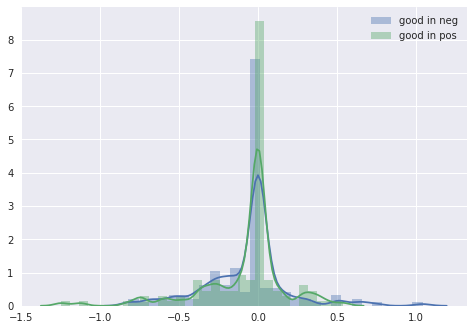

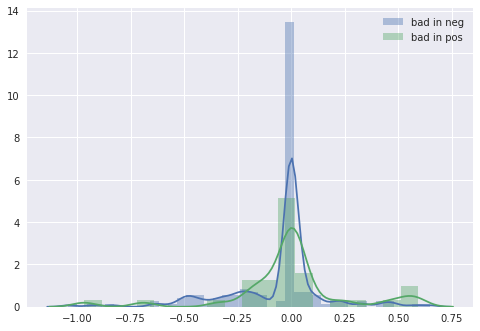

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(bg_data[0][check_words.index("good")], label="good in neg")
sns.distplot(bg_data[1][check_words.index("good")], label="good in pos")
plt.legend()
plt.show()

sns.distplot(bg_data[0][check_words.index("bad")], label="bad in neg")
sns.distplot(bg_data[1][check_words.index("bad")], label="bad in pos")
plt.legend()
plt.show()